In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from tqdm import tqdm
import pickle
import json
from os import listdir
from os.path import join, isfile
from scipy.sparse import load_npz
from scipy import sparse
from sklearn.ensemble import AdaBoostClassifier, StackingClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.multiclass import OneVsRestClassifier

from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.metrics import normalized_mutual_info_score, cohen_kappa_score

import time
import warnings
warnings.filterwarnings('ignore')

<h1>Training und Anwendung des Klassifikators</h1>

In diesem Notebook implementieren wir eine etwas kompaktere Variante des hierarchischen Klassifikators. Dieser besitzt nur zwei Ebenen, so dass die Zahl der zu trainierenden Modelle für den Workshop übersichtlich gehalten wird. Der Aufbau des Notebook Files ist wie folgt:

1. Extraktion der Hierarchieebenen und Zuordnung von Polygon-IDs
2. Einlesen der bisherigen Feature-Files
3. Codierung von verbleibenden Merkmalen
4. Implementierung des Stacked Classifiers für Kontextmerkmale
5. Implementierung des Ensemblings für Kontext- und Kontentergebnisse
6. Implementierung des Abstainings

<h2>1. Extraktion der Hierarchieebenen und Zuordnung von Polygon-IDs</h2>

Im Skript *1-CreateLabels.ipynb* hatten wir durch das agglomerative Clustering ein Dendrogramm von Polygon-IDs berechnet. Dieses ist im File *place_hierarchy.pcl* serialisiert. Der erste Schritt wird es nun sein, diese Datenstruktur zu durchlaufen und die Zwischenebene für die schrittweise Klassifikation zu identifizieren. Die erste Ebene klassifiziert hier, wie bekannt, in eine von vier Teilbereichen der Welt, etwa auf der räumlichen Präzision von Kontinenten. Die zweite Ebene würde von dieser Kontinentalebene nun abweichend direkt auf die 150 Zielklassen abbilden.

Zur Berechnung der vier Cluster, welche für den ersten Klassifikationsschritt relevant sind, definieren wir unten eine Hilfsfunktion *get_N_splits(tree, N)*. Diese erwartet eine Baumstruktur, welche dem Dendrogramm entspricht, über die iteriert werden kann, vgl. *tree*. Des Weiteren muss eine Zahl *N* von gewünschten Clustern übergeben werden. Der Output der Methode ist dann eine Liste, welche *N* weitere Listen enthält. Jede dieser *N* inneren Listen repräsentiert einen der gewünschten Cluster und beinhaltet für sich wiederum alle Polygon-IDs, welche diesem Cluster zugeordnet sind. Wir sehen unten gleich in der Praxis, wie die Datenstrukturen genau aussehen.

Die *N* Cluster erhält man aus dem Dendrogramm normalerweise, indem der Baum, von der Wurzel ausgehend, an seinen obersten *N* Abzweigungen zertrennt wird. Das Resultat sind dann *N* Teilbäume, welche die Polygon-IDs des entsprechenden Teilclusters in den Blättern halten. Anders als bei der soeben beschriebenen exakten Unterteilung implementieren wir für den Workshop eine etwas andere (leichtere) Variante, die Teilbäume zu berechnen. Konkret gehen wir davon aus, dass die Abzweigungen zumindest nahe der Wurzel ungefähr gleichmäßig auf beide Seiten des Baumes verteilt sind. In diesem Fall kann eine einfache Verarbeitungsvorschrift für Binärbäume angegeben werden, welche abhängig von der gewünschten Tiefe des Baumes (oder äquivalent gewünschten Zahl an Teilbäumen) die Split-Knoten bestimmt.

So wäre beispielsweise beim Split in $2$ Teilbäume (ausgehend von der Wurzel) einmal der **l**inke und einmal der **r**echte Teilbaum als eigenständiger Cluster zu betrachten. Soll ein Binärbaum gleichmäßig in $4$ Teile aufgeteilt werden, so könnten die Wurzeln der vier Teilbäume erreicht werden, indem folgendermaßen durch den Baum navigiert wird: a) links, links (kurz **ll**), b) links, rechts (kurz **lr**), c) rechts, links (kurz **rl**), sowie d) rechts, rechts (kurz **rr**). Ähnliches gilt für weitere Unterteilungen mit mehr Teilbäumen.

Damit die Funktion *get_N_splits()* nun die *N* Teilbäume extrahieren kann, wird im Code wie folgt vorgegangen. Wie bereits beschrieben, gehen wir vereinfachend davon aus, dass das Dendrogramm ein Binärbaum ist. Auf welcher Ebene der Baum zertrennt werden muss, um *N* Teilbäume auf gleicher Ebene zu erhalten, berechnen wir den Zweierlogarithmus von *N*. So bedeutet *required_depth* $= log_2(4) = 2$ etwa, dass wir zwei mal von der Wurzel ausgehend (auf insgesamt vier verschiedene Arten) durch den Baum navigieren müssen, um auf die vier unterschiedlichen Teilbäume zu kommen. Die Hilfsmethode *get_subtree_position(depth)* berechnet die Potenzmenge aller Navigationsmöglichkeiten auf dieser Tiefe des Baumes, für *N*$=4$ also bspw. [**ll**, **lr**, **rl**, **rr**].

Für jede dieser Durchlaufvorschriften, im Code unten als *subtrees* bezeichnet, durchlaufen wir nun das übergebene Dendrogramm *root* (von der Wurzel) aus, indem wir, je nach Character der Durchlaufvorschrift, auf den jeweils linken oder rechten Nachfolger referenzieren (vgl. *current_position.get_left()* oder *current_position.get_right()*. Sind wir dann bei der Wurzel des Teilbaumes angelangt, können alle in diesem Teilbaum verbleibenden Knoten dem Selben Cluster zugeordnet werden. Einer dieser *subtree_clusters* kann bspw. erhalten werden, indem auf dem aktuellen Teilbaum ein Preorder Baumdurchlauf durchgeführt wird: *current_position.pre_order()*.

Nach der Abarbeitung eines Teilbaumes kehren wir zur Wurzel zurück und extrahieren auf gleiche Weise den nächsten Teilbaum. Sind alle Teilbäume abgearbeitet, gibt die Funktion die Liste von Clustern zurück.

In [2]:
def get_subtree_position(depth):
    res = ["l", "r"]
    if depth > 1:
        children = get_subtree_position(depth - 1)
        res = [element + child for child in children for element in res]
    return res

In [3]:
def get_N_splits(root, N, balanced=True):
    
    if balanced:
        subtree_clusters = []

        # note that the hierarchical tree is not balanced, hence a too large N will result in an error eventually
        required_depth = np.log2(N)
        subtrees = get_subtree_position(required_depth)

        for subtree in subtrees:
            current_position = root  # start at root
            for char in subtree:  # navigate through the tree to find root of subtree
                if char == "l":
                    current_position = current_position.get_left()
                else:
                    current_position = current_position.get_right()
            subtree_clusters.append(current_position.pre_order())  # get all leaf nodes of current subtree
            
        return subtree_clusters
    else:  # not balanced
        subtrees = [root]
        
        while len(subtrees) < N:
            max_pos = -1
            max_len = -1
            
            # find largest subtree
            for i, subtree in enumerate(subtrees):
                l = len(subtree.pre_order())
                if l > max_len:
                    max_len = l
                    max_pos = i
                    
            # keep all smaller subtrees
            new_subtrees = [s for i, s in enumerate(subtrees) if i != max_pos]
            # and split the largest one
            new_subtrees.append(subtrees[max_pos].get_left())
            new_subtrees.append(subtrees[max_pos].get_right())
            subtrees = new_subtrees
            
        subtrees = [s.pre_order() for s in subtrees]
        return subtrees

In der nächsten Zeile werden die soeben definierten Hilfsfunktionen in der Praxis aufgerufen. Hierzu wird zunächst das serialisierte Dendrogramm aus dem File *place_hierarchy.pcl* geladen. Für den Workshop würde es nun ausreichen, die eine zusätzliche Hierarchieebene mit vier Clustern durch den Funktionsaufruf *get_N_splits(ch, 4)* zu extrahieren.

Für komplexere Szenarien mit mehr Ebenen muss der entsprechende Funktionsaufruf häufiger durchgeführt werden, nämlich einmal pro gewünschter Zahl an Cluster. Im Code unten ist dies bereits automatisiert geregelt. Hierzu wird ein Dictionary $C$ von Clustern erzeugt. Jedes Key-Value-Paar des Dictionarys hält dann die Informationen darüber, wie der Baum in eine feste, jedoch immer unterschiedliche Zahl von Clustern unterteilt wird. So würde beispielsweise der Aufruf *C[4]* eine Liste von $4$ Clustern mit Polygon-IDs zurück liefern, *C[16]* eine Liste von $16$ Clustern mit Polygon-IDs (das wäre im Projekt die zweite Ebene) usw...

Aus diesen Clusterergebnissen können nun die **Labels von Datenpunkten für die Zwischenebenen** berechnet werden. Auf Kontinentalebene, d.h. für vier Zielklassen, erwartet der Algorithmus nämlich natürlich nicht die 150 Polygon-IDs, sondern eine von vier Cluster-IDs. Glücklicherweise ist die Gruppierung bereits in der *C[4]* Liste enthalten, da dort ja die vier Listen von Polygon-IDs existieren. Wir stellen diese Datenstruktur nun noch so um, dass wir direkt von Polygon-ID auf Cluster-ID abbilden können, indem das entsprechende *C[4]* Dictionary transponiert wird. 

Das Ergebnis ist ein neues Dictionary *C4_T* (grob für "vier Cluster & transponiert"), welches als Keys die Polygon-IDs und als Values die entsprechende Cluster-ID besitzt. Wollen wir für das Training des Klassifikators erster Ebene nun also beispielsweise einen Datenpunkt des Polygons $55$ nutzen, so hätte dieses Polygon auf der dieser Ebene das Label *C4_T[55]*. 

Bei komplexeren Klassifikatoren mit mehr Ebenen (wie beispielsweise direkt im Projekt) müsste zusätzlich noch ein Mapping von $C4$-IDs auf $C16$-IDs vorgenommen werden. Der entsprechende Code ist unten in Kommentaren mit beigefügt. 

In [4]:
# Load hierarchy
ch = pickle.load(open("place_hierarchy.pcl", "rb"))

# Cluster Dictionary
C = {2**i: get_N_splits(ch, 2**i) for i in range(1,4)}
C4_T = {}
for cluster_id, members in enumerate(C[4]):
    for member in members:
        C4_T[member] = cluster_id

"""
C16_T = {}
for cluster_id, members in enumerate(C[16]):
    for member in members:
        C16_T[member] = cluster_id
        
C4_to_C16 = defaultdict(set)
# 4 -> 16 Mapping
for cluster_id, members in enumerate(C[4]):
    for member in members:
        C4_to_C16[cluster_id].add(C16_T[member])
"""

'\nC16_T = {}\nfor cluster_id, members in enumerate(C[16]):\n    for member in members:\n        C16_T[member] = cluster_id\n        \nC4_to_C16 = defaultdict(set)\n# 4 -> 16 Mapping\nfor cluster_id, members in enumerate(C[4]):\n    for member in members:\n        C4_to_C16[cluster_id].add(C16_T[member])\n'

Hier noch die versprochenen Beispiele, wie die Datenstrukturen jeweils aussehen. Wir beginnen mit der Naviagtionsvorschrift des Graphdurchlaufs, so dass insgesamt $8$ Teilbäume entstehen. Somit müssen $log_2(8)=3$ Navigationsschritte von der Wurzel aus durchgeführt werden. Diese sind:

In [5]:
get_subtree_position(3)

['lll', 'rll', 'lrl', 'rrl', 'llr', 'rlr', 'lrr', 'rrr']

Durchläuft man das Dendrogramm, so ergeben sich folgende Cluster mit entsprechenden Poylgon-IDs. Hier wird schnell ersichtlich, dass der Baum nicht ausbalanciert ist.

In [6]:
clusters = get_N_splits(ch, 8)
for i, c in enumerate(clusters):
    print("Cluster {}: {}".format(i, c))

Cluster 0: [97]
Cluster 1: [83, 137, 116, 76, 38, 125, 34, 99, 90, 17, 85, 72, 134, 135, 87, 4, 64, 67, 28, 136, 19, 111, 1, 143, 88, 148, 31, 53, 12, 68, 41, 117, 50, 124]
Cluster 2: [80, 49, 100, 5, 57, 141, 45, 114]
Cluster 3: [54, 144, 32, 65, 43, 15, 37, 109, 71, 59, 123, 70, 2, 103, 14, 128, 75, 18, 127, 8, 95, 30, 139, 42, 129, 36, 107]
Cluster 4: [26, 52, 138]
Cluster 5: [130, 73, 33, 48, 23, 69, 110, 16, 77, 56, 145, 79, 7, 122]
Cluster 6: [11, 92, 101, 147, 21, 74, 22, 51, 62, 94, 44, 86, 78, 140, 60, 119, 10, 47, 126, 106, 29, 149, 0, 105, 115, 133, 27, 58, 120, 131, 96, 40, 91, 3, 35, 132, 102, 25, 142, 55, 24, 82, 61, 113, 46, 108, 98, 13, 66]
Cluster 7: [9, 112, 81, 89, 20, 146, 63, 93, 6, 104, 84, 121, 39, 118]


Die transponierte Darstellung zu obigem Beispiel wäre:

In [7]:
C8_T = {}
for cluster_id, members in enumerate(C[8]):
    for member in members:
        C8_T[member] = cluster_id
C8_T

{97: 0,
 83: 1,
 137: 1,
 116: 1,
 76: 1,
 38: 1,
 125: 1,
 34: 1,
 99: 1,
 90: 1,
 17: 1,
 85: 1,
 72: 1,
 134: 1,
 135: 1,
 87: 1,
 4: 1,
 64: 1,
 67: 1,
 28: 1,
 136: 1,
 19: 1,
 111: 1,
 1: 1,
 143: 1,
 88: 1,
 148: 1,
 31: 1,
 53: 1,
 12: 1,
 68: 1,
 41: 1,
 117: 1,
 50: 1,
 124: 1,
 80: 2,
 49: 2,
 100: 2,
 5: 2,
 57: 2,
 141: 2,
 45: 2,
 114: 2,
 54: 3,
 144: 3,
 32: 3,
 65: 3,
 43: 3,
 15: 3,
 37: 3,
 109: 3,
 71: 3,
 59: 3,
 123: 3,
 70: 3,
 2: 3,
 103: 3,
 14: 3,
 128: 3,
 75: 3,
 18: 3,
 127: 3,
 8: 3,
 95: 3,
 30: 3,
 139: 3,
 42: 3,
 129: 3,
 36: 3,
 107: 3,
 26: 4,
 52: 4,
 138: 4,
 130: 5,
 73: 5,
 33: 5,
 48: 5,
 23: 5,
 69: 5,
 110: 5,
 16: 5,
 77: 5,
 56: 5,
 145: 5,
 79: 5,
 7: 5,
 122: 5,
 11: 6,
 92: 6,
 101: 6,
 147: 6,
 21: 6,
 74: 6,
 22: 6,
 51: 6,
 62: 6,
 94: 6,
 44: 6,
 86: 6,
 78: 6,
 140: 6,
 60: 6,
 119: 6,
 10: 6,
 47: 6,
 126: 6,
 106: 6,
 29: 6,
 149: 6,
 0: 6,
 105: 6,
 115: 6,
 133: 6,
 27: 6,
 58: 6,
 120: 6,
 131: 6,
 96: 6,
 40: 6,
 91: 6,
 3: 6,


<h2>2. Einlesen der bisherigen Feature Files</h2>

Zu diesem Zeitpunkt haben wir (fast) genügend Informationen gesammelt und aufbereitet, um mit dem Training der Klassifikatoren beginnen zu können. Daher ist es an der Zeit, die Vorverarbeiteten Tweets in den Arbeitsspeicher zu laden. Zur Erinnerung: wir verarbeiten Kontext- und Textmerkmale aus Tweets individuell. Die Textmerkmale wurden mit den Anweisungen des zweiten Skriptes *2-ExtractFeatures.ipynb* bereits klassifiziert und stehen als Wahrscheinlichkeitsverteilung über die $150$ Zielklassen in Form einer CSR-Matrix zur Verfügung. 

Die Kontextkomponenten sind noch nicht klassifiziert, da der zugehörige gestapelte Klassifikator in diesem Skript zunächst noch erstellt werden muss. Die Merkmale sind zudem in zwei unterschiedlichen Files abgelegt, nämlich einerseits einer **.features* CSV-Datei (in der kategorische Merkmale noch nicht in eine numerische Form übersetzt wurden) und andererseits einer **.loc* Datei, welche die Polygon-ID-Vorhersagen für die Profil-Locations der Nutzer hält.

In der Praxis existieren von all diesen Dateien mehrere Exemplare, da die initialen Tweet-Files auch in mehreren Files abgespeichert waren. Somit müssen in dieser Zelle a) zusammengehörige **.feature*, **.loc* und **.pred.npz* Dateien kombiniert werden und b) alle Paare von Dateien eingelesen werden, so dass der Datensatz vollständig in den Speicher geladen wird.

Hinsichtlich der Problematik a) muss nur überprüft werden, ob das File-Prefix der individuellen Dateien übereinstimmt. Die Problematik aus b) lässt sich über das Framework *pandas* auch sehr einfach lösen, da Teilmatrizen mit identischen Dimensionen einfach zu einer großen Matrix konkateniert werden können, siehe nächste Zelle.

Für die Ergebnisse der Textklassifikation werden noch zwei zusätzliche Verarbeitungsschritte getätigt, damit die Klassifikation später fortlaufend durchgeführt werden kann. Neben den gegebenen Wahrscheinlichkeitsverteilungen über die Zielklassen wird noch das wahrscheinlichste Label (in der Spalte $150$) angegeben. Zudem werden vier neue Spalten *4\_0*, ... *4\_3* erstellt, welche die Wahrscheinlichkeitswerte beinhalten, dass ein Datenpunkt aus dem Cluster $0$, ...$3$ der Ebene 1 (d.h. bei der Klassifikation in $4$ Klassen) entstammt. Diese Wahrscheinlichkeit berechnet sich entsprechend aus der Summe der Teilwahrscheinlichkeiten aller der aus diesem Cluster stammenden Polygon-IDs.

In [12]:
path = "data/feature_files/"
files = [path + f for f in listdir(path) if isfile(join(path, f))]

# Files vorbereiten
feature_files = [f for f in files if f[-8:] == "features"]
geocoding_files = [f for f in files if f[-3:] == "loc"]
text_files = [f for f in files if f[-8:] == "pred.npz"]

# Variablen definieren
tmp_feat = []
tmp_text = []
tmp_labels = []

for feature_file in tqdm(sorted(feature_files, reverse=True)):  # füŕ jedes File
    
    # Variablen zurücksetzen
    df_feat = None
    df_text = None
    df_labels = None
        
    file_prefix = feature_file.split(".")[0]
        
    # Filenamen filtern
    geo_file = [f for f in geocoding_files if file_prefix in f][0]
    text_file = [f for f in text_files if file_prefix in f][0]

    """
    Data Frames erstellen
    """
    # 1. Feature Data Frame
    df_feat = pd.read_csv(feature_file, delimiter=";")
        
    # Profile Location ist noch in einem anderen File abgespeichert, weil die vorherige Pipeline 
    # die Daten noch durch den Geocoder prozessieren lassen musste... hier findet der Merge statt
    df_geo = pd.read_csv(geo_file)
    df_feat["profile_location"] = df_geo["profile_location"]
    del df_geo
    tmp_feat.append(df_feat)
    
    # 2. Text Data Frame
    df_text = pd.DataFrame(sparse.load_npz(text_file).todense())
    df_text = df_text.iloc[1: , :]
    
    tmp_text.append(df_text)
    
    # 3. Label Data Frame
    df_labels = pd.DataFrame()
    df_labels["150"] = df_feat["label"]
    df_feat = df_feat.drop(columns="label")
    
    # Hierarchieebenen definieren
    df_labels["4"] = df_labels["150"].apply(lambda n: C4_T[n])
    
    """
    Text Wahrscheinlichkeiten für Layer 1 aufbereiten 
    (Top 10 Klassen mit W'keiten von Layer 2 sind gegeben)
    """
    # Zu Beginn sind die Labels 0..149 mit W'keiten gefüllt, falls sie in den Top 10 sind, sonst mit 0
    # Label 150 ist die Gegenw'keit, d.h. 1- Summe(Top10)
    
    # Diskretisiere Text-Label für Layer 2 via Argmax:
    df_text["150"] = df_text.idxmax(axis=1)  # get argmax cluster id for each data point
    
    # Falls Gegenw'keit > .5, d.h. Vorhersage unsicher war, dann deklariere Datenpunkt als -1, also
    # als "unschlüsslig"
    df_text["150"] = df_text["150"].apply(lambda n: n if n != 150 else -1)  # Top Predictions < .5

    # sum the probabilities of subclusters that belong into the same cluster
    for i, member in enumerate(C[4]):
        df_text["4_{}".format(i)] = 0
        for m in member:
            df_text["4_{}".format(i)] += df_text[m]
    
    tmp_labels.append(df_labels)


    
df_feat = pd.concat(tmp_feat, axis=0, ignore_index=True)
df_text = pd.concat(tmp_text, axis=0, ignore_index=True)
df_labels = pd.concat(tmp_labels, axis=0, ignore_index=True)

del tmp_feat
del tmp_text
del tmp_labels

100%|██████████| 25/25 [00:01<00:00, 20.06it/s]


Betrachten wir die nun die Ergebnisse der Extraktion. 

Das *df_labels* Dataframe enthält die Labels aller grob $46000$ Datenpunkte. Die Spalte $150$ bezieht sich dabei auf die Polygon-ID, d.h. das korrekte Label bei $150$ Möglichkeiten. Die Spalte $4$ beinhaltet das Label des Clusters, wenn der Datenpunkt auf der ersten Hierarchieebene in einen von eben $4$ Clustern vorhergesagt werden muss.

Das *df_text* Dataframe enthält, wie bereits bekannt, die Wahrscheinlichkeitsverteilungen über die 150 Zielklassen, sowie die Gegenwahrscheinlichkeit aka Noise. Zusätzlich ist das wahrscheinlichste Label, sowie die Wahrscheinlichkeitsverteilung für Cluster der ersten Ebene in vier Zielklassen gegeben.

Das *df_feat* Dataframe enthält nun alle Kontextmerkmale, d.h. auch die Profil-Location des Nutzers. Jedoch müssen hier noch Daten aus den kategorischen Spalten, wie *language* oder *source* konvertiert werden.

In [13]:
df_labels

,150,4
0,94,2
1,40,2
2,106,2
3,29,2
4,147,2
...,...,...
46430,35,2
46431,115,2
46432,49,2
46433,132,2


In [14]:
df_text

,0,1,2,3,4,5,6,7,8,9,...,146,147,148,149,150,150,4_0,4_1,4_2,4_3
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.072442,83,0.0,0.927558,0.000000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.009680,55,0.0,0.138538,0.851782,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.304313,83,0.0,0.562199,0.133488,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.048659,30,0.0,0.218158,0.000000,0.733183
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.179389,83,0.0,0.820611,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46430,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.010000,55,0.0,0.147621,0.842379,0.000000
46431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.186476,83,0.0,0.758250,0.000000,0.055274
46432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.109235,83,0.0,0.890765,0.000000,0.000000
46433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.001278,83,0.0,0.931571,0.067151,0.000000


In [15]:
df_feat

,label,post_created,dc,wt,language,friends,followers,statuses,lists,account_created,profile_language,source,profile_location
0,94,-0.931228,11,27,en,0.263466,0.333942,0.462209,-0.809151,0.703763,en,Twitter for iPhone,-1
1,40,-0.931237,10,13,pt,-0.113006,0.030997,0.646550,-0.879588,-0.951713,pt,Twitter for Android,-1
2,106,-0.931241,11,11,en,0.528658,0.523527,0.529468,-0.111957,-0.581559,en,Twitter for iPhone,106
3,29,-0.931250,11,30,en,0.123284,-0.070287,0.259564,-0.688739,0.011612,en,Twitter for Android,29
4,147,-0.931238,11,14,en,0.299875,0.312595,1.000000,-0.554423,-0.227811,en,Twitter for iPhone,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46430,35,-0.995000,11,21,pt,-0.042921,-0.463031,0.161453,-1.000000,-0.464452,es,Twitter for iPhone,35
46431,115,-0.995055,11,29,en,0.310309,0.138039,0.619081,-0.618303,0.402051,en,Twitter for iPhone,115
46432,49,-0.995008,10,1,en,0.056590,-0.205291,0.414067,-0.720412,-0.818716,en,Twitter for iPhone,49
46433,132,-0.995039,11,27,en,0.228311,0.144375,0.849746,-0.720412,0.777447,pt,Twitter for Android,132


<h2>3. Codierung der verbleibenden Merkmale</h2>

Wir nutzen einfache Label-Encodings für die Konvertierung der kategorischen Achsen. Ein Label Encoder codiert kategorische Werte dabei in eine fortlaufende numerische Ganzzahl. Alternativ sind hier One-Hot-Encoding, Binärencoding o.ä. möglich. **Die hier trainierten Encoder müssen zwangsläufig auf der Festplatte abgespeichert werden, damit sie für den Anwendungsbetrieb zur Verfügung stehen.**

Die erste Konvertierung betrifft die Sprachkomponente von Tweets, welche momentan in zwei Spalten abgebildet ist, namentlich *language*, also der von Twitter bereitgestellten Sprache und in *profile_language*, d.h. die durch das Sprachensemble berechnete Sprache des Profilinhalts von Nutzern. Sollte im Profil eine Sprache erkannt werden, welche zuvor in den *language*-Objekten der Tweet noch nie gesehen wurden, so wird diese Sprache vor der Codierung der Einfachheit halber auf den rauschbehafteten "en"-Sprachtag abgeändert (vgl. Auswertungen zur Merkmalskorrelation). Dies reduziert die Anzahl an unterschiedlichen Sprachlabels für den Klassifikator.

Mit Hilfe der Methode *encoder.transform(data)* kann ein Array von kategorischen Daten in einen numerischen Vektor transformiert werden, wenn der Encoder zuvor trainiert wurde und alle im Array vorkommenden Werte bekannt sind, d.h. zuvor beobachtet wurden. Umgekehrt könnte das codierte Array auch wieder in eine String-Repräsentation zurück übersetzt werden (bspw. wenn eine händische Inspektion der Datenpunkte gewünscht ist). Hierzu existiert eine entsprechende *encoder.inverse_transform(encoded_data)* Funktion, die hier im Code aber nicht genutzt wird.

Die zweite Konvertierung ist bei der Quellplattform, d.h. der Spalte *source*, notwendig. Auch hier nutzen wir, ähnlich wie bei der Sprachkodierung, einen kleinen Trick, um die Zahl der resultierenden Labels gering zu halten (ist hier zwangsläufig notwendig, da wir mit sehr wenig Trainingsdaten arbeiten). Hierzu werden die beobachtbaren Werte der *source*-Kategorie durch die Funkion *value_counts()* aufgelistet und gezählt. Wir beschränken uns dann auf die häufigsten $9$ beobachtbaren Quellplattformen. Alle anderen Plattformen werden kollektiv auf einen Defaultwert *other* abgebildet. Durch diese Abbildung existieren somit insgesamt $10$ verschiedene Quellplattformen. Diese werden entsprechend durch einen weiteren Label Encoder in numerische Werte übersetzt.

Am Ende der Zelle wird die nun fertig vorverarbeitete Eingangsmatrix *df_feat* gezeigt. Theoretisch könnten Spalten mit Ganzzahlen, bspw. die der Encodings, noch auf einen Wertebereich $\in [-1; 1]$ normalisiert werden. Dies wird hier jedoch übergangen.

In [16]:
# encode language
selected_languages = df_feat["language"].unique()
df_feat["profile_language"] = df_feat["profile_language"].apply(lambda n: n if n in selected_languages else "en")

language_encoder = LabelEncoder().fit(selected_languages)
df_feat["language"] = language_encoder.transform(df_feat["language"])
df_feat["profile_language"] = language_encoder.transform(df_feat["profile_language"])

pickle.dump(language_encoder, open("language_encoder.pcl", "wb"))

# encode source
selected_sources = list(df_feat["source"].value_counts().keys()[:9])  # value counts werden per default sortiert
df_feat["source"] = df_feat["source"].apply(lambda n: n if n in selected_sources else "other")
selected_sources.append("other")

source_encoder = LabelEncoder().fit(selected_sources)
df_feat["source"] = source_encoder.transform(df_feat["source"])

pickle.dump(source_encoder, open("source_encoder.pcl", "wb"))

df_feat

,label,post_created,dc,wt,language,friends,followers,statuses,lists,account_created,profile_language,source,profile_location
0,94,-0.931228,11,27,2,0.263466,0.333942,0.462209,-0.809151,0.703763,2,7,-1
1,40,-0.931237,10,13,6,-0.113006,0.030997,0.646550,-0.879588,-0.951713,6,5,-1
2,106,-0.931241,11,11,2,0.528658,0.523527,0.529468,-0.111957,-0.581559,2,7,106
3,29,-0.931250,11,30,2,0.123284,-0.070287,0.259564,-0.688739,0.011612,2,5,29
4,147,-0.931238,11,14,2,0.299875,0.312595,1.000000,-0.554423,-0.227811,2,7,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46430,35,-0.995000,11,21,6,-0.042921,-0.463031,0.161453,-1.000000,-0.464452,3,7,35
46431,115,-0.995055,11,29,2,0.310309,0.138039,0.619081,-0.618303,0.402051,2,7,115
46432,49,-0.995008,10,1,2,0.056590,-0.205291,0.414067,-0.720412,-0.818716,2,7,49
46433,132,-0.995039,11,27,2,0.228311,0.144375,0.849746,-0.720412,0.777447,6,5,132


Hier eine exemplarische Rücktransformation von Encodings:

In [17]:
df_feat["language"] = language_encoder.inverse_transform(df_feat["language"])
print(df_feat)
df_feat["language"] = language_encoder.transform(df_feat["language"])

       label  post_created  dc  wt language   friends  followers  statuses  \
0         94     -0.931228  11  27       en  0.263466   0.333942  0.462209   
1         40     -0.931237  10  13       pt -0.113006   0.030997  0.646550   
2        106     -0.931241  11  11       en  0.528658   0.523527  0.529468   
3         29     -0.931250  11  30       en  0.123284  -0.070287  0.259564   
4        147     -0.931238  11  14       en  0.299875   0.312595  1.000000   
...      ...           ...  ..  ..      ...       ...        ...       ...   
46430     35     -0.995000  11  21       pt -0.042921  -0.463031  0.161453   
46431    115     -0.995055  11  29       en  0.310309   0.138039  0.619081   
46432     49     -0.995008  10   1       en  0.056590  -0.205291  0.414067   
46433    132     -0.995039  11  27       en  0.228311   0.144375  0.849746   
46434    116     -0.994994  11  21       fr -0.133073  -0.136655  0.362956   

          lists  account_created  profile_language  source  pro

<h2> 4. Implementierung des gestapelten Klassifikators für Kontextmerkmale</h2>

Es müssen hier insgesamt fünf Modelle trainiert werden, eines für Ebene 1 (Kontinente) mit Labels der vier Clustern. Vier weitere, die jeweils nur Datenpunkte aus einem dieser vier Cluster erkennen und hochfrequentere Strukturen und Ergebnisse, d.h. eine Kategorisierung auf Polygon-ID-Ebene durchführen müssen.

Wir beginnen mit dem Kontinentalmodell. Da in den Vorarbeiten bereits ausführliche Untersuchungen von möglichen Klassifikatormodellen getätigt wurden, werden diese Codefragmente im Folgenden übersprungen. Somit konzentrieren wir uns auf den verhältnismäßig kurzen Ergebnisteil.

Zunächst werden Merkmalsmatrix *df_feat* und Zielvektor *df_labels* in entsprechende Variablen *X* und *y* kopiert. Dies hat den Vorteil, dass der ursprüngliche Datensatz bei der Veränderung der temporären Variablen unberührt bleibt und dieser somit für die nachfolgenden Klassifikatoren wieder verwendet werden kann.

In [18]:
X = df_feat
y = df_labels["4"]
y.value_counts()

2    36384
1     7020
3     2906
0      125
Name: 4, dtype: int64

Wie ersichtlich, sind die Datenpunkte für diesen kleinen Beispieldatensatz verhältnismäßig unausgewogen bzgl. Größe, ein Samplebalancing sollte also angewandt werden.

In [19]:
balancer = SMOTE()
X, y = balancer.fit_resample(X, y)
y.value_counts()

3    36384
2    36384
1    36384
0    36384
Name: 4, dtype: int64

In [20]:
X

,label,post_created,dc,wt,language,friends,followers,statuses,lists,account_created,profile_language,source,profile_location
0,94,-0.931228,11,27,2,0.263466,0.333942,0.462209,-0.809151,0.703763,2,7,-1
1,40,-0.931237,10,13,6,-0.113006,0.030997,0.646550,-0.879588,-0.951713,6,5,-1
2,106,-0.931241,11,11,2,0.528658,0.523527,0.529468,-0.111957,-0.581559,2,7,106
3,29,-0.931250,11,30,2,0.123284,-0.070287,0.259564,-0.688739,0.011612,2,5,29
4,147,-0.931238,11,14,2,0.299875,0.312595,1.000000,-0.554423,-0.227811,2,7,144
...,...,...,...,...,...,...,...,...,...,...,...,...,...
145531,128,-0.949701,10,13,2,-0.066147,-0.141182,0.403878,-1.000000,-0.561951,2,5,128
145532,20,-0.985942,10,21,2,0.251187,0.566083,0.561659,-0.378456,-0.012570,2,7,20
145533,20,-0.969095,10,21,2,-0.057592,0.008485,0.725709,-0.625448,0.737300,2,7,-1
145534,144,-0.982295,10,14,2,-0.196338,-0.337915,0.566578,-0.868163,-0.426169,2,5,-1


In der Merkmalsmatrix kann nicht erkannt werden, ob es sich um einen realen oder synthetischen Datenpunkt handelt.

Somit ist es an der Zeit den gestapelten Klassifikator zu definieren. Hierzu erstellt man zunächst eine *estimator_list*, die Tupel der Form *(identifikator, modell)* enthält. *Identifikator* bezieht sich hierbei auf eine selbst gewählte String-Repräsentation des Modells/der Modellgruppe, die beispielsweise dazu genutzt werden kann, um bei gridbasierten CV-Verfahren Parameterranges für Hyperparameter festzulegen. *Modell* wiederum muss eine Instanz eines einfachen oder zusammengesetzten Klassifikators im Sinne der sklearn-Objekthierarchie sein. Diesem Modell können entweder direkt oder über den zugewiesenen *identifikator* Parametrisierungen übergeben werden.

Die *estimator_list* bezieht sich auf die erste Ebene des gestapelten Klassifikators, d.h. einer Zusammenfügung als einem globalen Multiclass-Modells und vielen lokalen Modellen. Wir beginnen bei der Erklärung des Codes mit dem einfacheren globalen Modell. Wie unten ersichtlich wird dieser als ein konventionelles Bagging-Modell instanziiert, welches intern $200$ Schätzer (standardmäßig Entscheidungsbäume) verwendet. Gleichzeitig erlaubt der Parameter *n_jobs* ein parallelisiertes Training mit bis zu *n_jobs* simulatenen Prozessen ($-1$ bedeutet hier alle verfügbaren Cores). Es sei jedoch angemerkt, dass bei solch gestapelten Modellen die maximale Prozesszahl teilweise vom übergeordneten Modell geerbt bzw. beschränkt wird.

Ähnlich wie beim globalen Modell könnte nun auch pro Zielklasse ein lokales Modell der *estimator_list* beigefügt werden. Der In- bzw. Output des Klassifikators ist jedoch eine Multiclass-Vorhersage, weswegen dieser Klassifikationstyp von jedem Teilmodell geerbt wird. Würden nun also vier lokale Modelle *locals$_1$*, ...*locals$_4$* eingefügt werden, würde jedes Modell eine dem globalen Klassifikator gleichwertige Multiclass-Klassifikation durchführen - nicht das Ziel unserer Auswertungen.

Für eine derartige Klassifikationsaufgabe existiert jedoch praktischerweise eine vordefinierte Wrapper-Klasse, der sog. *OneVsAllClassifier*, vgl. https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html. Diesem Wrapper muss ein konkreten Klassifikatormodell übergeben werden, welches als lokaler Klassifikator verwendet werden soll. Beim Training des Modells, d.h. beim Aufruf der *fit()* Funktion werden dann so viele lokale Klassifikatoren gespawnt, wie es unterschiedliche Zielklassen gibt. Der Wrapper kümmert sich hierbei selbstständig um die Konvertierung der Klassenlabels für jedes individuelle Modell. Gleichzeitig kümmert sich der Wrapper um das Ensembling der Teilergebnisse jedes lokalen Modells. Jedoch kann jedes lokale Modell auch händisch referenziert und evaluiert werden.

Nach der Definition der *estimator_list*, das heißt der Menge an Modellen auf der oberen Ebene des gestapelten Klassifikators muss dieser selbst noch erstellt werden. Auch hierfür existiert ein gleichnamiger Wrapper *StackingClassifier*. Diesem muss zunächst die Liste an Teilmodellen, sowie ein Ensembling-Verfahren zur Zusammenführung aller Teilergebnisse als *final_estimator* übergeben werden. Es sei angemerkt, dass ein Estimator des StackingClassifiers auch wieder ein StackingClassifier sein kann, wodurch ein Stacking Classifier mit mehreren Ebenen, ähnlich einem Neuronalen Netz, jedoch mit unterschiedlichen Aktivierungen, entstehen würde.

Als interessant gestalten sich die für den StackingClassifier verfügbaren Parameter. Insbesondere soll hier kurz über drei Werte diskutiert werden. Die *stack_method* bezieht sich dabei auf den Vorhersagetyp des Klassifikators. Konventionell wird ein vortrainiertes Modell mit einem der beiden Funktionen *predict()* oder *predict_proba()* angewandt, d.h. die Vorhersage ist entweder diskretisiert oder eben eine Wahrscheinlichkeitsverteilung über alle Zielklassen. Nun existiert jedoch nicht für jedes Klassifikatormodell die (informativere) probabilistische Vorhersage. In der *stack_method* muss nun angegeben werden, auf welche Ausgabe der Gesamtklassifikator trainiert werden soll. Im hier übergebenen Modus *auto* wird zunächst, falls alle Estimator diese Funktion implementieren, die *predict_proba()* Variante bevorzugt.

Der Parameter *passthrough* bezieht sich darauf, ob die auf erster Ebene eingegeben Merkmale, neben den Vorhersagen der *estimator_list*, an den *final_estimator* übergeben werden sollen, oder nicht. Wir entscheiden uns aktiv gegen diese Option, da somit die gesamte Aussagekraft des Modells durch die Vorhersagen der lokalen Modelle kommen **muss** und die Vorhersage nicht (im worst case) in eine Logistische Regression des Eingabevektors mit 0-Gewichten der vorherigen *estimator_list* degeneriert.

Schließlich kann eine automatisch durchgeführte Kreuzvalidierung des *final_estimators* angestoßen werden, wenn eine Zahl *N* an gewünschten Folds an den *cv* Parameter übergeben wird.

In [21]:
estimator_list = [("locals", OneVsRestClassifier(estimator=AdaBoostClassifier(n_estimators=10), n_jobs=-1)), 
                ('global', BaggingClassifier(n_estimators=10, n_jobs=-1))]

model = StackingClassifier(estimators=estimator_list, 
                           final_estimator=LogisticRegression(),
                           stack_method="auto",
                           passthrough=False,
                           cv=3,
                           n_jobs=100,
                           verbose=1)

Training und Test des Modells der ersten Ebene kann auf viele Arten durchgeführt werden. Folgender Code reduziert sich auf das Minimum und vermeidet komplexere, aber statistisch fundiertere Ergebnisse.

In [22]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
t0 = time.time()
# model.fit(X_train, y_train)
model.fit(X[:30000], y[:30000])

print("Training complete, took {} seconds.".format(round(time.time()-t0), 2))

Training complete, took 5 seconds.


In [23]:
# model.score(X_test, y_test)
model.score(X[30000:], y[30000:])

0.8823050823985598

Die Modellqualitäten sind aufgrund der Datenmenge mit Vorsicht zu genießen, der Code ist jedoch auch auf größeren Eingabematrizen korrekt. Wollen wir nun einen einzelnen Tweet vorhersagen, so wäre das Ergebnis des ersten Klassifikators für Kontextmerkmale beispielsweise folgender:

In [24]:
model.predict_proba(X.to_numpy()[0].reshape(1, -1))

array([[2.62126577e-04, 4.01120070e-03, 9.93619118e-01, 2.10755427e-03]])

Auch könnte lediglich einer der lokalen Klassifikatoren gefragt werden, ob dieser den Datenpunkt kennt oder nicht. Die Referenzierung des Teilmodells erfolgt hier durch das *estimators_* Objekt.

In [25]:
model.estimators_[0].estimators_[0].predict_proba(X.to_numpy()[0].reshape(1, -1))

array([[0.80238137, 0.19761863]])

Ist man mit dem Modell zufrieden, sollte dieses persistiert werden..

In [26]:
pickle.dump(model, open("model_l1.pcl", "wb"))

Die gleiche Trainingsprozedur kann nun für die verbleibenden vier Modelle angestoßen werden. Wichtig ist nun jedoch, dass jedes Modell der zweiten Ebene nur auf denjenigen Datenpunkten trainiert wird, die auch wirklich in seinen Bereich fallen. Konkret bedeutet dies, dass das Teilmodell, welches sich auf den "Kontinent" Nordamerika beschränken soll, nicht mit Trainingsdaten aus europäischen Polygonen arbeiten sollte. Um dies zur erreichen wird zu Beginn jeder Iteration (eine Iteration trainiert genau einen Teilklassifikator) auf das entsprechende Subset an Datenpunkten gefiltert.

In [27]:
for i, c in tqdm(enumerate(np.bincount(df_labels["4"]))):

    # Filtern auf die relevante Teilmenge an Datenpunkten
    X = df_feat[df_labels["4"] == i]
    y = df_labels[df_labels["4"] == i]
    y = y["150"]
    
    # Rebalancing
    """
    try:
        balancer = SMOTE()
        X, y = balancer.fit_resample(X, y)
    except:
        print("Too few datapoints in classes: {}".format(np.bincount(y)))
        balancer = RandomOverSampler()
        X, y = balancer.fit_resample(X, y)
    """

    # train-test split
    # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)
    X_train = X[:int(X.shape[0] * 0.3)]
    X_test = X[int(X.shape[0] * 0.3):]
    y_train = y[:int(X.shape[0] * 0.3)]
    y_test = y[int(X.shape[0] * 0.3):]
    
    # Klassifikatormodell wie oben
    estimator_list = [("locals", OneVsRestClassifier(estimator=AdaBoostClassifier(n_estimators=5), n_jobs=-1)), 
                    ('global', BaggingClassifier(n_estimators=5, n_jobs=-1))]

    model = StackingClassifier(estimators=estimator_list, 
                               final_estimator=LogisticRegression(),
                               stack_method="auto",
                               passthrough=False,
                               n_jobs=100,
                               verbose=1)

    # Training
    t0 = time.time()
    model.fit(X_train, y_train)
    t1 = time.time()
    
    # Scoring
    score = model.score(X_test, y_test)
    
    # Modell persistieren
    pickle.dump(model, open("model_l2_c{}.pcl".format(i), "wb"))
    
    print("Layer 2 - Cluster {}: {} acc ({}s duration)\n".format(i, score, round(t1-t0, 2)))

1it [00:03,  3.74s/it]

Layer 2 - Cluster 0: 0.8295454545454546 acc (2.65s duration)



2it [00:14,  5.91s/it]

Layer 2 - Cluster 1: 0.9922669922669922 acc (9.68s duration)



3it [00:28,  8.15s/it]

Layer 2 - Cluster 2: 0.9999214731634536 acc (11.2s duration)



4it [00:37,  9.49s/it]

Layer 2 - Cluster 3: 0.9852579852579852 acc (8.58s duration)



<h2> 5. Implementierung des Ensemblings für Kontext- und Kontentergebnisse</h2>

Das Ensembling funktioniert relativ simpel: es kann als logistische Regression der Outputs von Kontext- und Kontentfeatures dargestellt werden. Prinzipiell könnte die gesamte Architektur als ein in sich geschlossenes Modell dargestellt werden (durch Schachtelung der oben beschriebenen Stacked Classifiers). Prototypisch kann es jedoch auch als separat trainierter Klassifikator umgesetzt werden, wie hier zu sehen.

Wir beginnen wieder mit dem Modell auf oberster Ebene. Für Training und Anwendung klassifzieren wir die gewünschten Datenpunkte zunächst mit dem bereits abgespeicherten Modell *stacked_classifier*. Dank der Methode *predict_proba()* erhalten wir eine Wahrscheinlichkeitsverteilung über die - hier - $4$ Zielklassen. Diese vier Wahrscheinlichkeitswerte korrespondieren zum Kontextoutput der Tweets und werden in die erste Outputvariable *y_1* geschrieben. Da der Text bereits zuvor klassifiziert wurde, können wir die entsprechende W'keitsverteilung direkt aus dem entsprechenden Dataframe auslesen und in die zweite Variable *y_2* schreiben.

Für das Ensembling konkatenieren wir *y_1* und *y_2* mit Hilfe der Funktion *np.hstack()*, also "staple die Vektoren horizontal" in einen neuen Eingabevektor. Das gewünschte Label dieser beiden Teilergebnisse ist weiterhin der bekannte Vektor *y*.

Wie unten ersichtlich, wird die logistische Regression auf den ersten 80% der Datenpunkte trainiert und auf den verbleibenden 20% getestet. Das trainierte Modell wird auch persistier.

An dieser Stelle sei vermerkt, dass im Rahmen des Workshops alle Klassifikatoren mit Ausnahme des Textklassifikators neu trainiert wurden. Daher sind die Textvorhersagen auf andere Klassenlabels ausgerichtet und die Werte der Textklassifikation für hier und später sind wenig aussagekräftig. Hier geht es vielmehr um den implementierungstechnischen Aspekt der Zusammenführung beider Teilergebnisse.

In [86]:
X = df_feat
y = df_labels["4"]

stacked_classifier = pickle.load(open("model_l1.pcl", "rb"))

In [33]:
y_1 = stacked_classifier.predict_proba(df_feat)  # get probability distribution for each sample
y_2 = df_text[["4_0", "4_1", "4_2", "4_3"]]  # get text probability distribution
y = df_labels["4"]  # get target labels

N = len(y)
meta_res = (np.argmax(y_1, axis=1) == y).value_counts()[1]/N
text_res = (np.argmax(y_2.to_numpy(), axis=1) == y).value_counts()[1]/N

lr = LogisticRegression().fit(np.hstack((y_1[:int(0.8*N)], y_2[:int(0.8*N)])), y[:int(0.8*N)])
combined_res = lr.score(np.hstack((y_1[int(0.8*N):], y_2[int(0.8*N):])), y[int(0.8*N):])

print(meta_res, text_res, combined_res)
pickle.dump(lr, open("ensemble_l1.pcl", "wb"))

0.945493700872187 0.346850436093464 0.9766340045224507


Für die Ensembles auf der zweiten Ebene kann prinzipiell wieder der selbe Code genutzt werden, wobei hier nun zusätzliche Arbeit anfällt, um die Labels korrekt miteinander zu vergleichen. Zunächst wird im Label-Dataframe über die vier verschiedenen Cluster iteriert. Jeder Cluster benötigt ein eigenes Modell. Entsprechende Filteroperationen für Kontext-, Kontent- und Label-Dataframes sind eingebaut.

In [302]:
for i, c in tqdm(enumerate(np.bincount(df_labels["4"]))):

    # Filtern auf die relevante Teilmenge an Datenpunkten
    X = df_feat[df_labels["4"] == i]
    X_text = df_text[df_labels["4"] == i]
    y = df_labels[df_labels["4"] == i]
    y = y["150"]
            
    stacked_classifier = pickle.load(open("model_l2_c{}.pcl".format(i), "rb"))
    
    
    y_1 = stacked_classifier.predict_proba(X)  # get probability distribution for each sample
    y_2 = X_text["150"]  # get text probability distribution
    
    classes = stacked_classifier.classes_.tolist()
    
    # y = [classes.index(x) if x in classes else -1 for x in y]
    
    
    N = len(y)
    meta_res = np.count_nonzero(np.argmax(y_1, axis=1) == [classes.index(x) if x in classes else -1 for x in y])/N
    text_res = np.count_nonzero(y_2 == [classes.index(x) if x in classes else -1 for x in y])/N
    
    y_2 = X_text[[x for x in classes]]
    
    lr = LogisticRegression().fit(np.hstack((y_1[:int(0.8*N)], y_2[:int(0.8*N)])), y[:int(0.8*N)])
    combined_res = lr.score(np.hstack((y_1[int(0.8*N):], y_2[int(0.8*N):])), y[int(0.8*N):])

    print(meta_res, text_res, combined_res)
    pickle.dump(lr, open("ensemble_l2_c{}.pcl".format(i), "wb"))

0it [00:00, ?it/s]

0.856 0.0 0.76


2it [00:00,  2.58it/s]

0.994017094017094 0.019515669515669517 0.9914529914529915


3it [00:05,  1.58s/it]

0.9999175461741425 0.00032981530343007914 0.9995877422014566


4it [00:05,  1.38s/it]

0.9872677219545767 0.0020646937370956643 0.9845360824742269


Unten ist noch ein beispielhafter Codeausschnitt, wie die aufbereiteten Tweet Files automatisch ausgewertet werden. Der Code ist den Zeitreihenauswertungen aus Quartal 4 entnommen. Der konkrete Aufbau des Skripts ist hier nahezu identisch zum Training, mit der Änderung, dass nun eben nur die *model.predict_proba()* Methode aufgerufen und händisch mit den Ground Truth Class Labels verglichen wird.

In [ ]:
"""
Automatisierte Klassifikation von Zeitreihen
"""
path = "data/feature_files/"
files = [path + f for f in listdir(path) if isfile(join(path, f))]

# Files vorbereiten
feature_files = [f for f in files if f[-8:] == "features"]
geocoding_files = [f for f in files if f[-3:] == "loc"]
text_files = [f for f in files if f[-8:] == "pred.npz"]

# Variablen definieren
df_feat = None
df_text = None
df_labels = None

"""
Main Loop: Klassifikation für jeden Monat im Datensatz, hier jeweils als eigenes File
"""
for feature_file in tqdm(sorted(feature_files, reverse=True)):  # füŕ jedes File
    
    # Variablen zurücksetzen
    df_feat = None
    df_text = None
    df_labels = None
        
    file_prefix = feature_file.split(".")[0]
        
    # Filenamen filtern
    geo_file = [f for f in geocoding_files if file_prefix in f][0]
    text_file = [f for f in text_files if file_prefix in f][0]

    """
    Data Frames erstellen
    """
    # 1. Feature Data Frame
    df_feat = pd.read_csv(feature_file, delimiter=";")
    
    print(df_feat)
    break
    
    # Profile Location ist noch in einem anderen File abgespeichert, weil die vorherige Pipeline 
    # die Daten noch durch den Geocoder prozessieren lassen musste... hier findet der Merge statt
    df_geo = pd.read_csv(geo_file)
    df_feat["profile_location"] = df_geo["profile_location"]
    del df_geo
    
    # 2. Text Data Frame
    df_text = pd.DataFrame(sparse.load_npz(text_file).todense())
    
    # 3. Label Data Frame
    df_labels = pd.DataFrame()
    df_labels["150"] = df_feat["label"]
    df_feat = df_feat.drop(columns="label")
    
    """
    Data Preprocessing: Hierarchielabels extrahieren und Features codieren
    """
    
    # Hierarchieebenen definieren
    df_labels["4"] = df_labels["150"].apply(lambda n: C4_T[n])
    df_labels["16"] = df_labels["150"].apply(lambda n: C16_T[n])
    
    # Features codieren
    # Sprachen auf unser 9 Sprachen-Sample beschränken (unbekannte Sprachen werden auf 'en' gemappt)
    selected_languages = df_feat["language"].unique()
    df_feat["profile_language"] = df_feat["profile_language"].apply(lambda n: n if n in selected_languages else "en")
    df_feat["language"] = language_encoder.transform(df_feat["language"])
    df_feat["profile_language"] = language_encoder.transform(df_feat["profile_language"])
    
    # Sources auf bekannte Sources beschränken, ansonsten auf die Wildcard "other" mappen
    df_feat["source"] = df_feat["source"].apply(lambda n: n if n in source_encoder.classes_ else "other")
    df_feat["source"] = source_encoder.transform(df_feat["source"])    
    
    """
    Text Wahrscheinlichkeiten für Layer 1 und 2 aufbereiten 
    (Top 10 Klassen mit W'keiten von Layer 0 sind gegeben)
    """
    # Zu Beginn sind die Labels 0..149 mit W'keiten gefüllt, falls sie in den Top 10 sind, sonst mit 0
    # Label 150 ist die Gegenw'keit, d.h. 1- Summe(Top10)
    
    # Diskretisiere Text-Label für Layer 0 via Argmax:
    df_text["150"] = df_text.idxmax(axis=1)  # get argmax cluster id for each data point
    
    # Falls Gegenw'keit > .5, d.h. Vorhersage unsicher war, dann deklariere Datenpunkt als -1, also
    # als "unschlüsslig"
    df_text["150"] = df_text["150"].apply(lambda n: n if n != 150 else -1)  # Top Predictions < .5

    # sum the probabilities of subclusters that belong into the same cluster
    for i, member in enumerate(C[4]):
        df_text["4_{}".format(i)] = 0
        for m in member:
            df_text["4_{}".format(i)] += df_text[m]

    # sum the probabilities of subclusters that belong into the same cluster
    for i, member in enumerate(C[16]):
        df_text["16_{}".format(i)] = 0
        for m in member:
            df_text["16_{}".format(i)] += df_text[m]
            
    """
    Preprocessing fertig, Auswertungen beginnen ab hier.
    Auswertungen führen wir für jedes Layer individuell durch.
    """
        
    for layer in range(3):
        print("Layer:" + str(layer))
        # 1. Modell-Identifikatoren für aktuelles Layer laden
        layer_models = [f.split("ensemble_")[-1].split(".pcl")[0] for f in listdir(".") if isfile(f) and "ensemble_l{}".format(layer) in f]
        print("Models:" + str(layer_models))
        
        for model_str in layer_models:
            print("Current Model:" + model_str)
            # Stacked Classifier laden
            model = pickle.load(open(model_str, "rb"))
            # Text-Ensemble laden
            ensemble = pickle.load(open("ensemble_" + model_str + ".pcl", "rb"))
            
            # 2. Daten filtern auf aktuellen Cluster 
            # (Modell kann nichts vorhersagen, was es nicht kennt)
            
            # Gefilterte Dataframes identizieren wir hier mit _ am Ende
            df_feat_ = None
            df_labels_ = None
            df_text_ = None
            cluster_id = None
            
            # müssen hier zwischen Layer 0 und 1 bzw. 2 differenzieren, da die 
            # unteren Layers mehrere Modelle besitzen (eines pro Cluster)
            
            if layer == 0:
                df_feat_ = df_feat  # kein Filter nötig auf oberster Ebene
                df_labels_ = df_labels["4"]  # Layer 0 predicted auf 4 Klassen
                df_text_ = df_text[["4_0", "4_1", "4_2", "4_3"]]

            elif layer == 1:
                cluster_id = int(model_str.split("_c")[-1])
                # print("CID", cluster_id)
                
                df_labels_ = df_labels[df_labels["4"] == cluster_id]  # Filtere auf Cluster-ID
                df_feat_ = df_feat[df_labels["4"] == cluster_id]
                df_text_ = df_text[df_labels["4"] == cluster_id]
                df_labels_ = df_labels_["16"]  # Layer 1 predicted auf 16 Klassen
                df_text_ = df_text[["16_{}".format(x) for x in range(16)]]
                
            elif layer == 2:
                cluster_id = int(model_str.split("_c")[-1])
                
                df_labels_ = df_labels[df_labels["16"] == cluster_id]  # Filtere auf Cluster-ID
                df_feat_ = df_feat[df_labels["16"] == cluster_id]
                df_text_ = df_text[df_labels["16"] == cluster_id]
                
                df_labels_ = df_labels_["150"]  # Layer 3 predicted auf 150 Klassen
                df_text_ = df_text[[x for x in range(150)]]
                            
            # 3. Daten vorhersagen
            y_hat = model.predict(df_feat_)
            result = y_hat == df_labels_
            
            N = y_hat.shape[0]
            meta_res = (y_hat == df_labels_).value_counts()[1]/N
            text_res = (np.argmax(df_text_.to_numpy(), axis=1) == df_labels_).value_counts()[1]/N
            
            y_2= df_text_.idxmax(axis=1).to_numpy()
            y_2 = [int(x.split("_")[-1]) for x in y_2]
            combined_res = ensemble.score(np.hstack((y_hat[int(0.8*N):], np.ay_2[int(0.8*N):])), df_labels_[int(0.8*N):])

            
            print(meta_res, text_res, combined_res)
    
            
            print("----")


<h2>6. Implementierung des Abstainings</h2>

Für das Abstaining muss zunächst eine minimale Sicherheit, also ein Grenzwert pro Zielklasse bestimmt werden. Wir starten dabei mit der Häufigkeitsverteilung der Trainingsdaten auf die einzelnen Cluster und multiplizieren diesen Vektor mit einem immer größer werdenden Skalar. In jeder Iteration wird geprüft, wie sich die Modellqualitäten (Accuracy, NMI, Kappa) verändern. Das Vielfache des Häufigkeitsvektors, welches die besten Modellqualitäten besitzt, wird dann für die nachfolgende Anwendung genutzt. Da im Workshop mit einem zweistufigen Klassifikator gearbeitet wird, müssen lediglich für die oberste Ebene die Schwellwerte berechnet werden.

In [208]:
# Berechne Verteilung von Zielklassen
dist = np.bincount(df_labels["4"])
dist = np.bincount(df_labels["4"]) / np.sum(dist)
print(dist)

[0.00269193 0.15117907 0.78354689 0.0625821 ]


In [209]:
# Lade relevante Modelle auf Layer 1
stacked_classifier = pickle.load(open("model_l1.pcl", "rb"))
ensemble = pickle.load(open("ensemble_l1.pcl", "rb"))

Neben der Häufigkeitsverteilung sind noch die Vorhersagen, d.h. die probabilistischen Klassifikationsergebnisse der einzelnen Datenpunkte, sowie (zumindest zur Berechnung des Schwellwertes) die wahren Klsasenlabels erforderlich.

In [210]:
# Berechne vorhergesagte Klassenlabels

# Kontextmerkmale
y_1 = stacked_classifier.predict_proba(df_feat)
y_2 = df_text[["4_0", "4_1", "4_2", "4_3"]]

# Ensembling
y_pred = ensemble.predict_proba(np.hstack((y_1, y_2)))
print(y_pred)


# Extrahiere wahre Labels
y_true = df_labels["4"]
print(y_true)

[[1.69219144e-04 7.96754301e-03 9.91626653e-01 2.36584999e-04]
 [4.34043237e-05 8.26124653e-03 9.91485391e-01 2.09958537e-04]
 [1.31873714e-04 8.32170377e-03 9.91178208e-01 3.68214740e-04]
 ...
 [1.59784406e-04 7.47113588e-03 9.92130991e-01 2.38088915e-04]
 [1.56856601e-04 8.12841617e-03 9.91502374e-01 2.12353025e-04]
 [1.85453944e-03 9.44772086e-01 4.44592672e-02 8.91410708e-03]]
0        2
1        2
2        2
3        2
4        2
        ..
46430    2
46431    2
46432    2
46433    2
46434    1
Name: 4, Length: 46435, dtype: int64


Die nachfolgenden beiden Hilfsfunktionen setzen das Abstaining exemplarisch um. Die Funktion *abstain(tau)* nimmt hierzu einen Vektor entgegen, welcher die Schwellwerte aller Zielklassen beinhaltet. Dieser wird auf die Vorhersagen der Trainingsdatenpunkte, welche bereits in der Variable *y_pred* abgespeichert sind, angewandt. Der Output der *abstain(tau)* Funktion ist ein diskretes Klassenlabel. Dies ist entweder das Label, welches am weitesten den Schwellwert überschreitet, oder, falls keine der Klassen sicher genug vorhergesagt werden kann, ein entsprechender Defaultwert von $-1$.

Die Funktion *abstain_rate(tau)* wird nur für die nachfolgenden Plots benötigt und liefert den Prozentsatz an Datenpunkten, welcher mit dem übergebenen Schwellwertvektor *tau* nicht mehr klassifiziert werden würde.

In [335]:
def abstain(tau):
    y_abs = []
    for row in y_pred:
        y_abs.append(np.argmax(row/tau) if np.max(row/tau) > 1 else len(row))
    return np.asarray(y_abs)

def abstain_rate(tau):
    y_abs = abstain(tau)
    return y_abs.tolist().count(y_pred.shape[1] ) / y_abs.shape[0]

**Bestimmung von $\tau$**

Wir berechnen zunächst die Modellqualitäten (in Form von Acc, NMI und Kappa), falls kein Abstaining angewandt wird. In der zweiten und dritten Zeile werden die Modellqualitäten erneut mit variierenden Werten für $\tau$ berechnet.

100%|██████████| 35/35 [00:11<00:00,  3.18it/s]


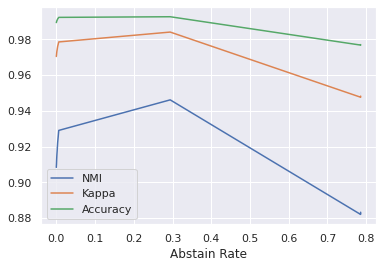

In [337]:
# Abstaining with varying Frequency threshold
alphas = np.linspace(0.5, 1.5, 35)

y1s = []
y2s = []
y3s = []
abstains = []
for alpha in tqdm(alphas):
    df = pd.DataFrame()
    df["y_true"] = y_true
    df["y_abs"] = abstain(alpha*dist)

    df_ = df[df["y_abs"] != len(dist)]
    y1s.append(normalized_mutual_info_score(df_["y_true"], df_["y_abs"]))
    y2s.append(cohen_kappa_score(df_["y_true"], df_["y_abs"]))
    y3s.append(np.count_nonzero(df_["y_true"] ==  df_["y_abs"]) / df[df["y_abs"] != 4].shape[0])
    abstains.append(1 - df_.shape[0] / df.shape[0])

plt.plot(abstains, y1s, label="NMI")
plt.plot(abstains, y2s, label="Kappa")
plt.plot(abstains, y3s, label="Accuracy")
plt.xlabel("Abstain Rate")
plt.legend()


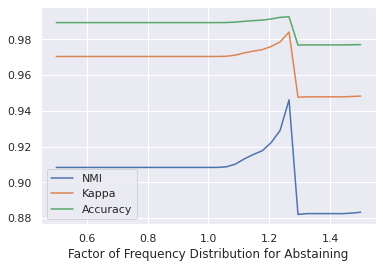

In [338]:
plt.plot(alphas, y1s, label="NMI")
plt.plot(alphas, y2s, label="Kappa")
plt.plot(alphas, y3s, label="Accuracy")
plt.xlabel("Factor of Frequency Distribution for Abstaining")
plt.legend()

Wir sehen also bereits grafisch, dass grob das $1.25$-fache der Häufigkeitsverteilung optimal hinsichtlich der Modellqualitäten ist. Wir entnehmen in der nächsten Zelle den genauen Wert und berechnen die hierdurch erhaltenen Modellqualitäten von allen verbleibenden Datenpunkten, d.h. diejenigen, welche nach dem Abstaining weiterhin klassifiziert werden.

In [216]:
alpha_opt = alphas[np.argmax(y1s)]
alpha_opt

1.2647058823529411

In [217]:
# Result without Abstaining
print("ACC: {}".format(np.count_nonzero(y_true == np.argmax(y_pred, axis=1)) / y_pred.shape[0]))
print("NMI: {}".format(normalized_mutual_info_score(y_true, np.argmax(y_pred, axis=1))))
print("Kappa: {}".format(cohen_kappa_score(y_true, np.argmax(y_pred, axis=1))))

ACC: 0.9865833961451491
NMI: 0.8917958071464861
Kappa: 0.9623048505124631


In [218]:
# Results with Abstaining

# get abstained results
y_abstained = abstain(dist*alpha_opt)

# filter on data points that are not omitted
y_true_ = y_true[np.where(y_abstained != dist.shape[0])[0]]
y_abstained_ = y_abstained[np.where(y_abstained != dist.shape[0])[0]]

#print(y_true.shape, y_abstained.shape, y_true_.shape, y_abstained_.shape)
# print results again
print("ACC: {}".format(np.count_nonzero(y_true_ == y_abstained_) / y_true_.shape[0]))
print("NMI: {}".format(normalized_mutual_info_score(y_true_, y_abstained_)))
print("Kappa: {}".format(cohen_kappa_score(y_true_, y_abstained_)))

ACC: 0.9926791324771985
NMI: 0.9461483821394397
Kappa: 0.98409945303947


In der nächsten Zelle ist abschließend eine Wrapper-Methode *classify_data()* zu sehen, welche einen vollständigen Klassifikationsschritt durch das hierarchische Modell samt Abstaining durchführt. Die Methode erwartet die Übergabe von drei Parametern:

- *X_context* ist die Kontext-Featurematrix
- *X_text* ist die Matrix der Textvorhersage
- *tau_opt* ist der zuvor berechnete Schwellwertsvektor

Im ersten Schritt werden die Klassifikationen auf der ersten Ebene durchgeführt. Hierzu werden zunächst die beiden notwendigen Modelle geladen (gestapelter Klassifikator + Ensembling Modell) und danach die übergebenen Datenmatrizen mittels *predict_proba()* auf den Klassifikatoren vorhergesagt. Wie ersichtlich müssen für das Ensembling-Modell die Kontext- und Text-Teilergebnisse zudem mit Hilfe der Funktion *np.hstack()* zu einem geschlossenen Vektor konkateniert werden.

Die Ergebnisse der Vorhersage der ersten Stufe (d.h. die Wahrscheinlichkeitsverteilungen auf die vier Cluster) werden sodann in eine Ausgabevariable *y_pred* geschrieben. Durch den Aufruf der bereits bekannten *abstain()* Methode werden diese probabilistischen Outputs in diskrete Klassenlabels umgewandelt. Der Ausgabewert ist hier entweder die ID eines Clusters, oder aber $-1$, falls kein Cluster den Schwellwert überschreitet.

Von diesem Punkt erfolgt die Weiterverarbeitung auf zwei Arten: Alle Datenpunkte, deren Ergebnisse im Sinne des Abstainings zu unsicher sind, werden nicht weiter klassifiziert, d.h. die Ausgabe würde $-1$, also "Enthaltung" liefern. Alle anderen Datenpunkte würden nun weiter klassifiziert werden. Dazu müssen die entsprechenden Datenpunkte an das korrekte Modell der zweiten Ebene weitergegeben werden.

Die finalen Klassifikationsergebnisse (hier vereinfacht in Form von diskreten Klassenlabels) werden in einer Variable *result* abgespeichert. Zunächst sind die Ausgabewerte aller Datenpunkte auf $-1$, also "Enthaltung" gesetzt. Im Laufe der Folgeklassifikationen werden aber alle klassifizierbaren Datenpunkte angepasst.

Die eigentlichen Vorhersagen der zweiten Ebene werden in der for-Schleife durchgeführt. Für jedes der vier Modelle (d.h. IDs 0-3) werden die entsprechenden Modelle der zweiten Ebene geladen und es wird auf diejenigen Datenpunkte gefiltert, welche auf Ebene 1 bereits in den korrekten Cluster einsortiert wurden. Nach der Berechnung der Outputs für Kontextmerkmale, der erneuten Kombination von Kontext- und Textergebnisse und der Berechnung des Ensemblings sind erneut in der Variable *y_pred_* die Ergebnisse der zweiten Ebene abgespeichert. Diese werden in den oben genannten *result*-Vektor geschrieben. 

Einzig neu ist die Konvertierung der Ausgabewahrscheinlichkeiten in die jeweiligen Polygon-IDs. Da Polygon-IDs nicht über die ClusterIDs hinweg sortiert sind, muss mit der temporären Liste *classes* ein Mapping von Ausgabeindex auf Polygon-ID erstellt werden.

In [326]:
def classify_data(X_context, X_text, tau_opt):
    
    # bekannte Hilfsfunktion
    def abstain():
        y_abs = []
        for row in y_pred:            
            y_abs.append(np.argmax(row/tau_opt) if np.max(row/tau_opt) > 1 else -1)
        return np.asarray(y_abs)

    # Klassifikation auf erster Ebene
    
    # Modelle laden
    stacked_classifier = pickle.load(open("model_l1.pcl", "rb"))
    ensemble = pickle.load(open("ensemble_l1.pcl", "rb"))
    
    # Vorhersagen tätigen
    y_1 = stacked_classifier.predict_proba(X_context)
    y_2 = X_text[["4_0", "4_1", "4_2", "4_3"]]
    
    # Ergebnisse mergen
    y_pred = ensemble.predict_proba(np.hstack((y_1, y_2)))
    
    # Ergebnisse abstainen
    y_pred = abstain()
    
    # Ausgabeliste vorbereiten
    results = np.ones(X_context.shape[0])
    results *= -1
    
    # genauere Klassifikation für alle verbleibenden Datenpunkte in vier Folgecluster
    for i in range(3):
        
        # Lade i-te Modelle auf 2. Ebene
        stacked_classifier = pickle.load(open("model_l2_c{}.pcl".format(i), "rb"))
        ensemble = pickle.load(open("ensemble_l2_c{}.pcl".format(i), "rb"))
        
        # filtere auf Datenpunkte, die vom i-ten Modell vorhergesagt werden müssen
        relevant_indices = np.where(y_pred == i)[0]
        if len(relevant_indices) == 0:
            continue
        X_context_ = X_context.iloc[relevant_indices, :]
        classes = ensemble.classes_.tolist()

        # Vorhersagen tätigen
        y_1 = stacked_classifier.predict_proba(X_context_)
        y_2 = X_text.iloc[relevant_indices, :]        
        #y_2 = y_2["150"]
        y_2 = y_2[[x for x in stacked_classifier.classes_]]
        
        y_pred_ = ensemble.predict_proba(np.hstack((y_1, y_2)))
        
        for i, v in zip(relevant_indices, y_pred_):
            v = np.argmax(v)
            results[i] = classes[v]
    
    
    return results

Die Anwendung obiger Funktion ist sehr simpel, siehe nachfolgende Zelle:

In [330]:
res = classify_data(df_feat, df_text, dist*alpha_opt)
res

array([ 94.,  40., 106., ...,  49., 132., 116.])